In [2]:
!pip install tabpfn
!pip install "tabpfn-extensions[all] @ git+https://github.com/PriorLabs/tabpfn-extensions.git"

  Using cached tabpfn-2.2.0-py3-none-any.whl.metadata (29 kB)
  Using cached eval_type_backport-0.2.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached tabpfn_common_utils-0.1.8-py3-none-any.whl.metadata (5.3 kB)
  Using cached posthog-6.7.5-py3-none-any.whl.metadata (6.0 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.6/173.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 8.9 MB/s eta 0:00:00
  Cloning https://github.com/PriorLabs/tabpfn-extensions.git to /tmp/pip-install-9etyfdb6/tabpfn-extensions_a80723a71fa24d6aa065a08e212d40d9
  Running command git clone --filter=blob:none --quiet https://github.com/PriorLabs/tabpfn-extensions.git /tmp/pip-install-9etyfdb6/tabpfn-extensions_a80723a71fa24d6aa065a08e212d40d9
  Resolved https://github.com/PriorLabs/tabpfn-extensions.git to commit 4fa9d52fdd6e543f8e880f17a52b22ef349ed954
  Installing build dependencies ... done
  Getting requirements

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tabpfn import TabPFNRegressor
from tabpfn import TabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNRegressor
from sklearn.model_selection import train_test_split
import torch

In [4]:
# 2. Load Dataset
df = pd.read_csv('student-mat.csv', sep=';')

In [5]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [7]:
# 3. Feature Engineering
df['pass_fail'] = (df['G3'] >= 10).astype(int)
df['grade_trend'] = df['G2'] - df['G1']
bins = [-1, 0, 5, 10, 20, 100]
labels = ['0', '1-5', '6-10', '11-20', '21+']
df['absences_bin'] = pd.cut(df['absences'], bins=bins, labels=labels)


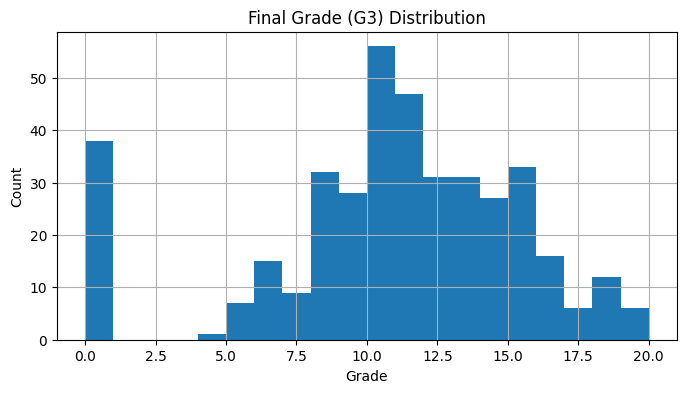

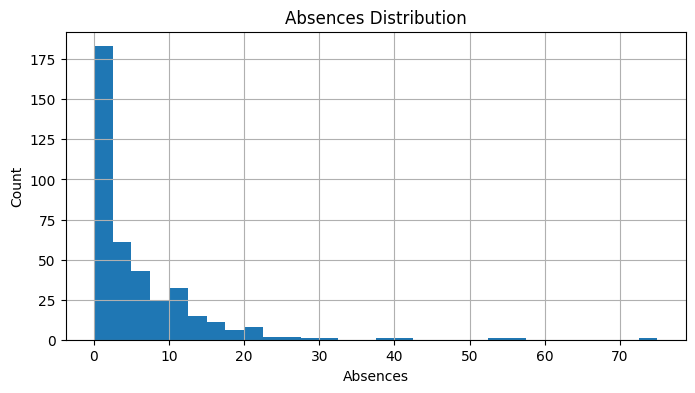

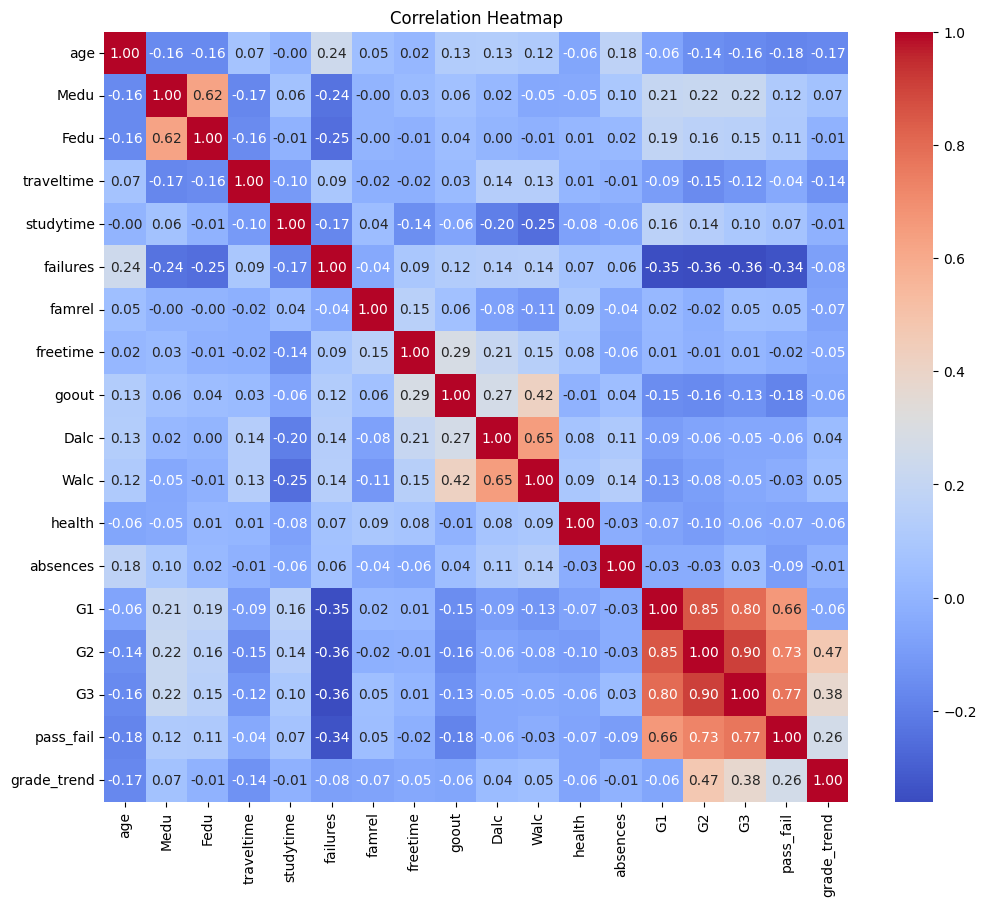

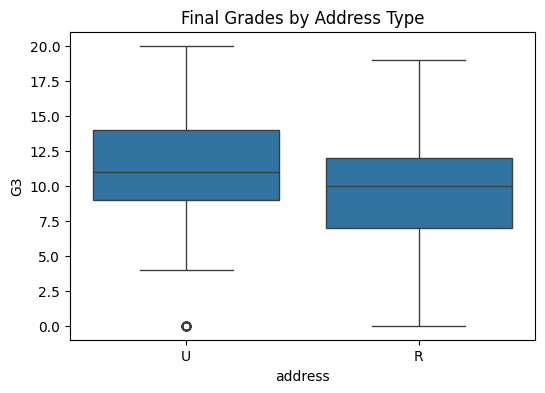

In [8]:
# 4. Exploratory Data Analysis (Plots)
plt.figure(figsize=(8, 4))
df['G3'].hist(bins=20)
plt.title('Final Grade (G3) Distribution')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 4))
df['absences'].hist(bins=30)
plt.title('Absences Distribution')
plt.xlabel('Absences')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='address', y='G3', data=df)
plt.title('Final Grades by Address Type')
plt.show()

In [9]:
# 5. Define Features & Targets
features = df.drop(columns=['grade_trend', 'G1', 'G2', 'G3', 'pass_fail', 'absences'])
y_reg = df['G3']
y_clf = df['pass_fail']

In [10]:
# 6. Split Dataset
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(features, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features, y_clf, test_size=0.2, random_state=42)

In [11]:
# 7. Preprocessing
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = features.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [12]:
# 8. Model Pipelines
ridge_model = Pipeline([
    ('prep', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])
rf_reg_model = Pipeline([
    ('prep', preprocessor),
    ('rf_reg', RandomForestRegressor(n_estimators=100))
])
logreg_model = Pipeline([
    ('prep', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])
rf_clf_model = Pipeline([
    ('prep', preprocessor),
    ('rf_clf', RandomForestClassifier(n_estimators=100))
])

In [13]:
# 9. Train Models
ridge_model.fit(X_train_r, y_train_r)
rf_reg_model.fit(X_train_r, y_train_r)
logreg_model.fit(X_train_c, y_train_c)
rf_clf_model.fit(X_train_c, y_train_c)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'Medu', 'Fedu',
                                                   'traveltime', 'studytime',
                                                   'failures', 'famrel',
                                                   'freetime', 'goout', 'Dalc',
                                                   'Walc', 'health']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus', 'Mjob',
                                                   'Fjob', 'reason', 'guardian',
                                                   'schoolsup', 'famsup',
                                                   'paid', 'activities',
                                                   'nursery', 'higher',
                                                   'internet', 'romantic',
                                                   'absences_bin'])])),
                ('rf_clf', RandomForestClassifier())])

In [14]:
# 10. Predictions
y_pred_ridge = ridge_model.predict(X_test_r)
y_pred_rf_reg = rf_reg_model.predict(X_test_r)
y_pred_logreg = logreg_model.predict(X_test_c)
y_pred_rf_clf = rf_clf_model.predict(X_test_c)

In [15]:
# 11. Evaluation
print("Regression (Ridge):")
ridge_r2 = r2_score(y_test_r, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test_r, y_pred_ridge)
print("R2:", ridge_r2)
print("RMSE:", ridge_rmse)
print("MAE:", ridge_mae)

print("\nRegression (Random Forest):")
rf_r2 = r2_score(y_test_r, y_pred_rf_reg)
rf_rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_rf_reg))
rf_mae = mean_absolute_error(y_test_r, y_pred_rf_reg)
print("R2:", rf_r2)
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)


print("\nClassification (Logistic Regression):")
logreg_accuracy = accuracy_score(y_test_c, y_pred_logreg)
logreg_precision = precision_score(y_test_c, y_pred_logreg)
logreg_recall = recall_score(y_test_c, y_pred_logreg)
logreg_f1 = f1_score(y_test_c, y_pred_logreg)
logreg_conf_matrix = confusion_matrix(y_test_c, y_pred_logreg)
print("Accuracy:", logreg_accuracy)
print("Precision:", logreg_precision)
print("Recall:", logreg_recall)
print("F1 Score:", logreg_f1)
print("Confusion Matrix:\n", logreg_conf_matrix)

print("\nClassification (Random Forest):")
rf_clf_accuracy = accuracy_score(y_test_c, y_pred_rf_clf)
rf_clf_precision = precision_score(y_test_c, y_pred_rf_clf)
rf_clf_recall = recall_score(y_test_c, y_pred_rf_clf)
rf_clf_f1 = f1_score(y_test_c, y_pred_rf_clf)
rf_clf_conf_matrix = confusion_matrix(y_test_c, y_pred_rf_clf)
print("Accuracy:", rf_clf_accuracy)
print("Precision:", rf_clf_precision)
print("Recall:", rf_clf_recall)
print("F1 Score:", rf_clf_f1)
print("Confusion Matrix:\n", rf_clf_conf_matrix)

Regression (Ridge):
R2: 0.19179584357219925
RMSE: 4.070904620572616
MAE: 3.3101059598877076

Regression (Random Forest):
R2: 0.1700245999124811
RMSE: 4.125370869403935
MAE: 3.2682278481012665

Classification (Logistic Regression):
Accuracy: 0.6708860759493671
Precision: 0.7096774193548387
Recall: 0.8461538461538461
F1 Score: 0.7719298245614035
Confusion Matrix:
 [[ 9 18]
 [ 8 44]]

Classification (Random Forest):
Accuracy: 0.6582278481012658
Precision: 0.6811594202898551
Recall: 0.9038461538461539
F1 Score: 0.7768595041322314
Confusion Matrix:
 [[ 5 22]
 [ 5 47]]


In [55]:
# Determine input feature dimension
input_dim = X_train_r.shape[1]

In [56]:
#12. Preprocessing for Neural Network
X_train_r_processed = preprocessor.fit_transform(X_train_r)
X_test_r_processed = preprocessor.transform(X_test_r)
X_train_c_processed = preprocessor.transform(X_train_c)
X_test_c_processed = preprocessor.transform(X_test_c)
# Convert to numpy arrays and ensure numeric types
X_train_r_processed = X_train_r_processed.astype(np.float32)
X_test_r_processed = X_test_r_processed.astype(np.float32)
y_train_r = y_train_r.astype(np.float32)
y_test_r = y_test_r.astype(np.float32)
X_train_c_processed = X_train_c_processed.astype(np.float32)
X_test_c_processed = X_test_c_processed.astype(np.float32)
y_train_c = y_train_c.astype(np.float32)
y_test_c = y_test_c.astype(np.float32)

In [65]:
# 13. Neural Network for Regression (Predicting Final Grade G3)
# Define the regression model architecture
model_reg = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_r_processed.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

# Compile the regression model
model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Using Mean Squared Error (MSE) loss for regression; tracking Mean Absolute Error (MAE) as a metric
model_reg.summary()  # Print model architecture summary

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Train the regression model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_reg = model_reg.fit(X_train_r_processed, y_train_r,
                            validation_split=0.1,  # use 10% of training data for validation
                            epochs=100,
                            batch_size=32,
                            callbacks=[early_stop],
                            verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 113.7118 - mae: 9.5725 - val_loss: 94.8103 - val_mae: 9.0939
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98.3468 - mae: 9.0693 - val_loss: 71.8042 - val_mae: 7.8936
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 66.2721 - mae: 7.3118 - val_loss: 48.6184 - val_mae: 6.3630
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 48.3278 - mae: 6.0854 - val_loss: 29.0183 - val_mae: 4.5724
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 32.3699 - mae: 4.7325 - val_loss: 19.2436 - val_mae: 3.4014
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.7268 - mae: 3.8063 - val_loss: 17.3531 - val_mae: 3.0680
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 32.1534 - mae: 4.4034 - val_loss: 16.2251 - val_mae: 2.9952
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.4277 - mae: 3.4786 - val_loss: 15.5853 - val_mae: 2.9443
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

In [67]:
# Evaluate the regression model on the test set
y_pred_reg = model_reg.predict(X_test_r_processed).flatten()  # Predict and flatten to 1D array

# Calculate performance metrics for regression
r2 = r2_score(y_test_r, y_pred_reg)
mse = mean_squared_error(y_test_r, y_pred_reg)
rmse = np.sqrt(mse)
mae_val = mean_absolute_error(y_test_r, y_pred_reg)

print("Regression model performance on test set:")
print(f"R^2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae_val:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Regression model performance on test set:
R^2 Score: 0.167
RMSE: 4.132
MAE: 3.238


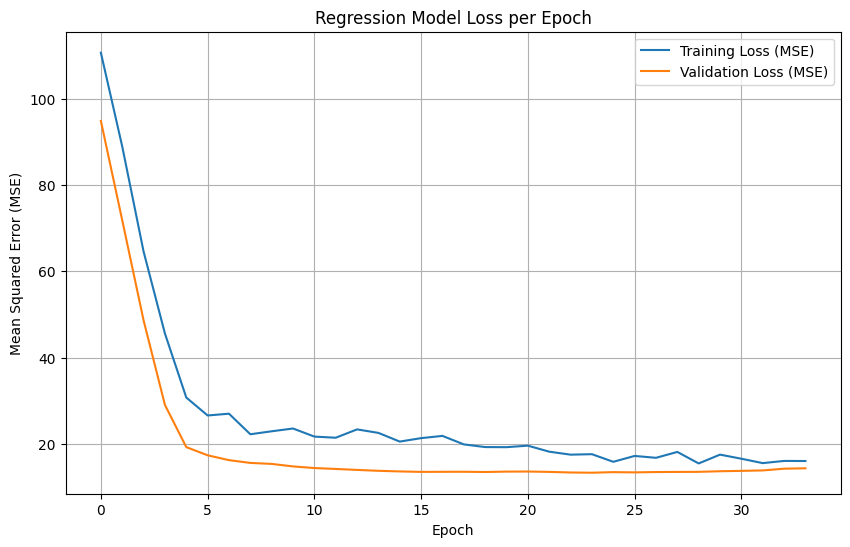

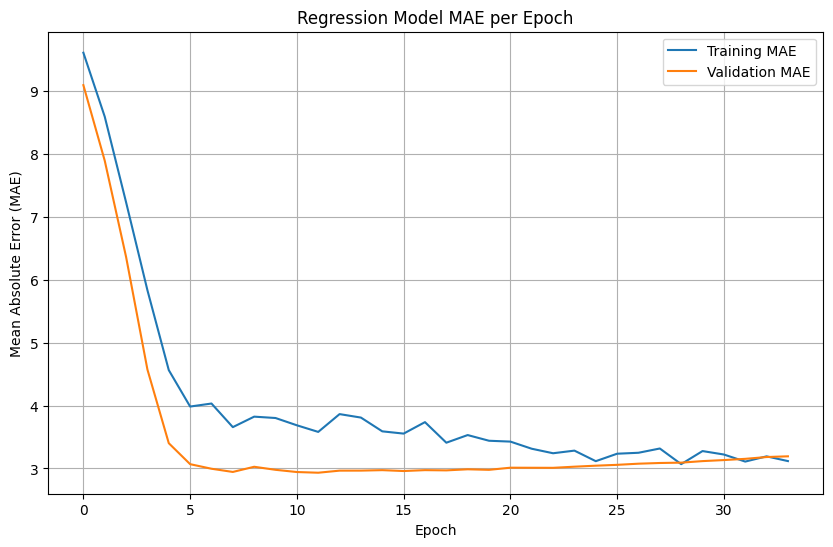

In [68]:
# Plotting training history (loss) for the regression model
plt.figure(figsize=(10, 6))
plt.plot(history_reg.history['loss'], label='Training Loss (MSE)')
plt.plot(history_reg.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Regression Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training history (metric - MAE) for the regression model
plt.figure(figsize=(10, 6))
plt.plot(history_reg.history['mae'], label='Training MAE')
plt.plot(history_reg.history['val_mae'], label='Validation MAE')
plt.title('Regression Model MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# 14. Neural Network for Classification (Predicting Pass/Fail)
# Define model
model_clf = keras.Sequential([
    layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_c_processed.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(16, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile model with explicitly named metrics
model_clf.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',  # 'accuracy' is already a consistent key
        tf.keras.metrics.Precision(name='precision'),  # Explicitly name Precision
        tf.keras.metrics.Recall(name='recall')        # Explicitly name Recall
    ]
)

model_clf.summary() # Print model architecture summary

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,017 (7.88 KB)

 Non-trainable params: 96 (384.00 B)

In [23]:
# Train the classification model
early_stop_clf = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Increased patience
history_clf = model_clf.fit(X_train_c_processed, y_train_c,
                            validation_split=0.1,  # use 10% of training data for validation
                            epochs=200, # Increased epochs, relies on early stopping
                            batch_size=32,
                            callbacks=[early_stop_clf],
                            verbose=1)


Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3634 - loss: 0.9946 - precision: 0.7085 - recall: 0.1659 - val_accuracy: 0.4375 - val_loss: 0.7986 - val_precision: 0.6667 - val_recall: 0.1053
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4060 - loss: 0.9166 - precision: 0.6905 - recall: 0.2173 - val_accuracy: 0.4688 - val_loss: 0.7787 - val_precision: 0.7500 - val_recall: 0.1579
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4266 - loss: 0.9182 - precision: 0.6662 - recall: 0.2045 - val_accuracy: 0.4688 - val_loss: 0.7617 - val_precision: 0.7500 - val_recall: 0.1579
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4108 - loss: 0.9245 - precision: 0.7163 - recall: 0.2511 - val_accuracy: 0.5000 - val_loss: 0.7471 - val_precision: 0.8000 - val_recall: 0.2105
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4523 - loss: 0.8186 - precision: 0.7565 - recall: 0.3015 - val_accuracy: 0.5938 - val_loss: 0.7366 - val

In [24]:
# Evaluate the classification model on the test set
y_pred_proba_clf = model_clf.predict(X_test_c_processed)
y_pred_clf_nn = (y_pred_proba_clf > 0.5).astype(int).flatten() # Convert probabilities to binary predictions

# Calculate performance metrics for classification
nn_clf_accuracy = accuracy_score(y_test_c, y_pred_clf_nn)
nn_clf_precision = precision_score(y_test_c, y_pred_clf_nn)
nn_clf_recall = recall_score(y_test_c, y_pred_clf_nn)
nn_clf_f1 = f1_score(y_test_c, y_pred_clf_nn)
nn_clf_conf_matrix = confusion_matrix(y_test_c, y_pred_clf_nn)

print("\nNeural Network Classification model performance on test set:")
print(f"Accuracy: {nn_clf_accuracy:.3f}")
print(f"Precision: {nn_clf_precision:.3f}")
print(f"Recall: {nn_clf_recall:.3f}")
print(f"F1 Score: {nn_clf_f1:.3f}")
print("Confusion Matrix:\n", nn_clf_conf_matrix)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Neural Network Classification model performance on test set:
Accuracy: 0.722
Precision: 0.727
Recall: 0.923
F1 Score: 0.814
Confusion Matrix:
 [[ 9 18]
 [ 4 48]]


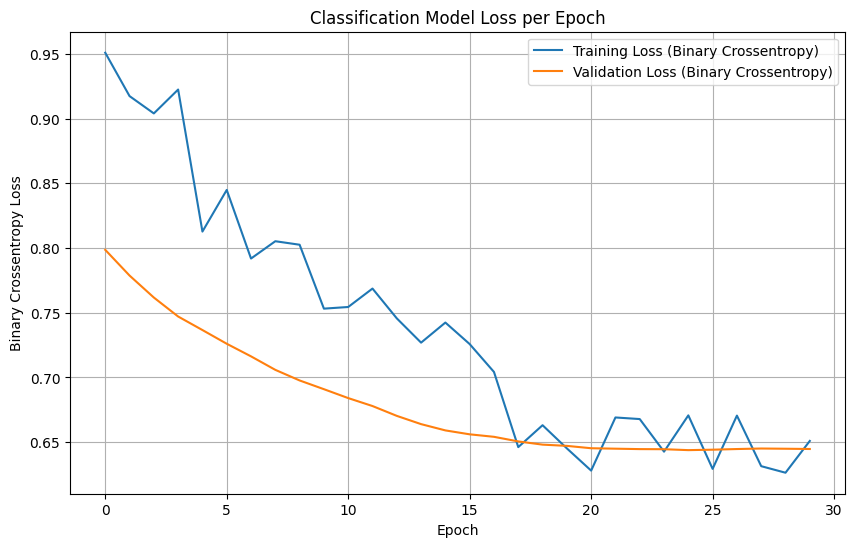

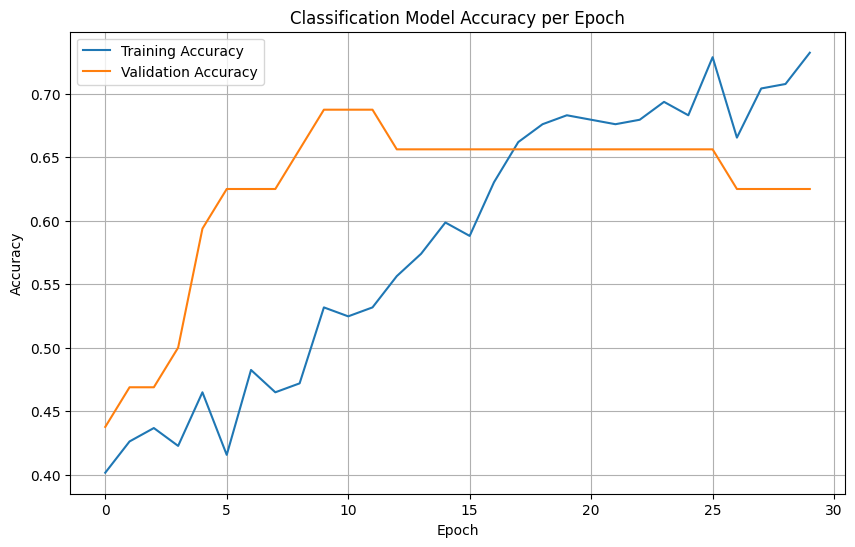

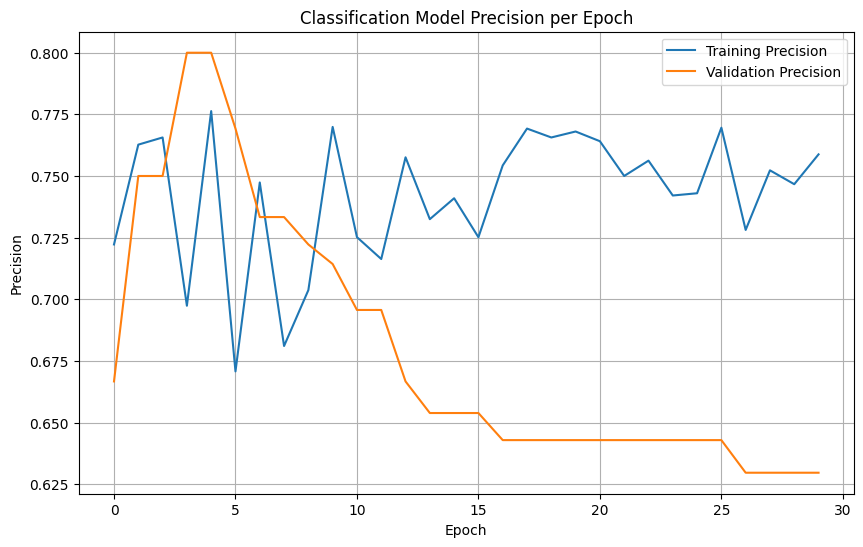

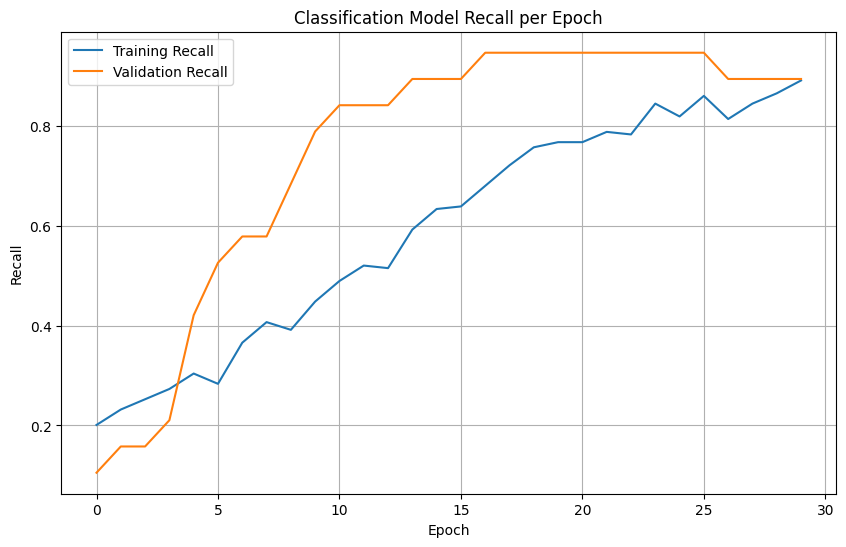

In [25]:
# Plotting training history (loss) for the classification model
plt.figure(figsize=(10, 6))
plt.plot(history_clf.history['loss'], label='Training Loss (Binary Crossentropy)')
plt.plot(history_clf.history['val_loss'], label='Validation Loss (Binary Crossentropy)')
plt.title('Classification Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training history (accuracy) for the classification model
plt.figure(figsize=(10, 6))
plt.plot(history_clf.history['accuracy'], label='Training Accuracy')
plt.plot(history_clf.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training history (Precision) for the classification model
plt.figure(figsize=(10, 6))
plt.plot(history_clf.history['precision'], label='Training Precision')
plt.plot(history_clf.history['val_precision'], label='Validation Precision')
plt.title('Classification Model Precision per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training history (Recall) for the classification model
plt.figure(figsize=(10, 6))
plt.plot(history_clf.history['recall'], label='Training Recall')
plt.plot(history_clf.history['val_recall'], label='Validation Recall')
plt.title('Classification Model Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
#15. TabPFN Regression Model
# Use the preprocessor to handle categorical and numerical features
X_train_processed_tabpfn = preprocessor.transform(X_train_r)
X_test_processed_tabpfn = preprocessor.transform(X_test_r)

# Convert to numpy arrays and ensure float32 type as required by TabPFN
X_train_arr = X_train_processed_tabpfn.astype('float32')
X_test_arr = X_test_processed_tabpfn.astype('float32')

y_train_arr = y_train_r.to_numpy().astype('float32')
y_test_arr = y_test_r.to_numpy().astype('float32')


# Train the TabPFN model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

reg = TabPFNRegressor(device=device)
reg.fit(X_train_arr, y_train_arr)

# Predict and evaluate
y_pred_tabpfn_reg = reg.predict(X_test_arr)
print("TabPFN Regressor RMSE:", np.sqrt(mean_squared_error(y_test_arr, y_pred_tabpfn_reg)))
print("TabPFN Regressor R²:", r2_score(y_test_arr, y_pred_tabpfn_reg))

Using device: cpu


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFN Regressor RMSE: 3.98019824545463
TabPFN Regressor R²: 0.2274109125137329


In [27]:
#16. Auto TabPFN Rgression Model

auto_reg = AutoTabPFNRegressor(max_time=500, device=device)

# Apply preprocessing to X_train_r and X_test_r (original DataFrames)
X_train_processed = preprocessor.transform(X_train_r)
X_test_processed = preprocessor.transform(X_test_r)

auto_reg.fit(X_train_processed, y_train_r.values)
y_pred2 = auto_reg.predict(X_test_processed)
print("AutoTabPFNRegressor RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred2)))
print("AutoTabPFNRegressor R²:", r2_score(y_test_r, y_pred2))

tabpfn-v2-regressor-09gpqh39.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.1

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


tabpfn-v2-regressor-2noar4o2.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/usr/local/lib/python3.12/dist-packages/tabpfn/regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


AutoTabPFNRegressor RMSE: 4.0137802220777585
AutoTabPFNRegressor R²: 0.21431881189346313


In [28]:
#17. TabPFN Classification Model

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['grade_trend', 'G1', 'G2', 'G3', 'pass_fail', 'absences']), y_clf, test_size=0.2)
clf = TabPFNClassifier()  # v2 used by default

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/tabpfn/classifier.py:484: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Accuracy: 0.6835443037974683
F1-score: 0.6535946039344179
              precision    recall  f1-score   support

           0       0.60      0.32      0.42        28
           1       0.70      0.88      0.78        51

    accuracy                           0.68        79
   macro avg       0.65      0.60      0.60        79
weighted avg       0.67      0.68      0.65        79



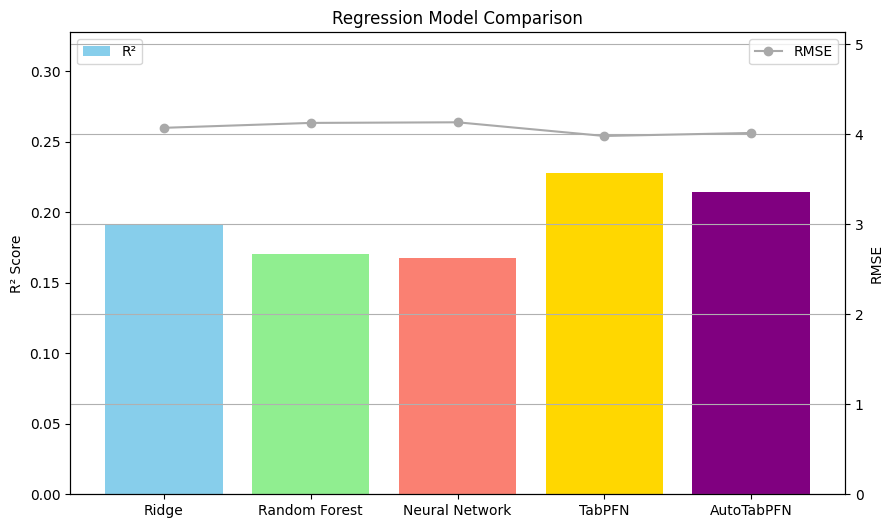

In [69]:
#18. Comparison between all Regression models

# Add TabPFN Regressor results to the comparison
models = ['Ridge', 'Random Forest', 'Neural Network', 'TabPFN', 'AutoTabPFN']
r2_scores = [ridge_r2, rf_r2, r2, r2_score(y_test_arr, y_pred_tabpfn_reg), r2_score(y_test_r, y_pred2)]
rmse_scores = [ridge_rmse, rf_rmse, rmse, np.sqrt(mean_squared_error(y_test_arr, y_pred_tabpfn_reg)), np.sqrt(mean_squared_error(y_test_r, y_pred2))]


fig, ax1 = plt.subplots(figsize=(10,6)) # Increase figure size
ax1.bar(models, r2_scores, color=['skyblue','lightgreen','salmon', 'gold', 'purple'], label='R²') # Added colors
ax1.set_ylabel('R² Score')
ax1.set_ylim(0, max(r2_scores)+0.1)

ax2 = ax1.twinx()
ax2.plot(models, rmse_scores, color='darkgray', marker='o', linestyle='-', label='RMSE') # Added linestyle
ax2.set_ylabel('RMSE')
ax2.set_ylim(0, max(rmse_scores)+1)

ax1.set_title("Regression Model Comparison")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True) # Added grid
plt.show()

/usr/local/lib/python3.12/dist-packages/tabpfn/classifier.py:484: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(



TabPFN Classification model performance on test set:
Accuracy: 0.722
Precision: 0.721
Recall: 0.942
F1 Score: 0.817
Confusion Matrix:
 [[ 8 19]
 [ 3 49]]


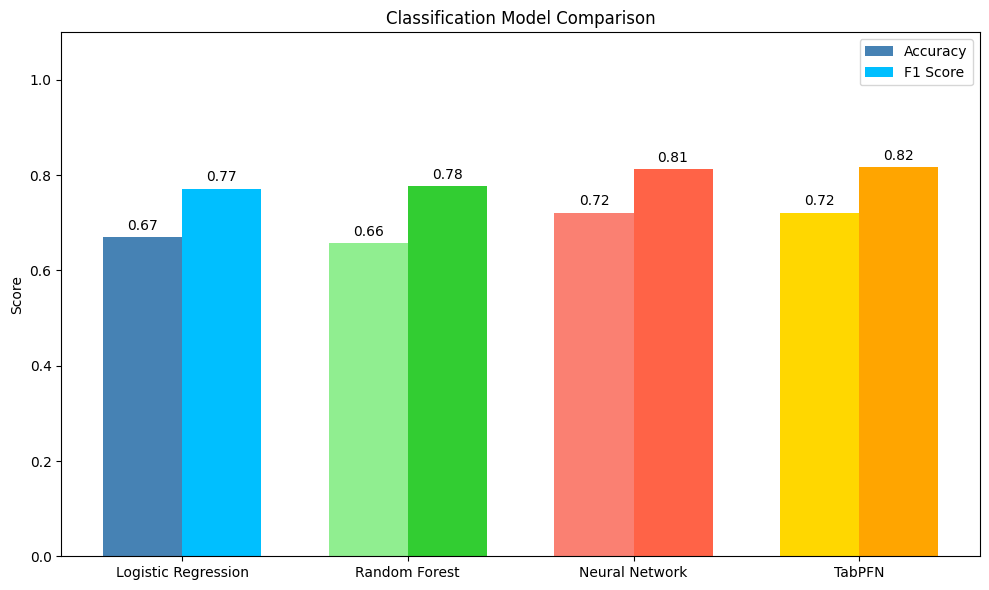

In [30]:
#19. Comparison between all Classification models

# TabPFN Classification
X_train_c_processed_tabpfn = preprocessor.transform(X_train_c)
X_test_c_processed_tabpfn = preprocessor.transform(X_test_c)

# Convert to numpy arrays for TabPFNClassifier
X_train_c_arr = X_train_c_processed_tabpfn.astype('float32')
X_test_c_arr = X_test_c_processed_tabpfn.astype('float32')

y_train_c_arr = y_train_c.to_numpy()
y_test_c_arr = y_test_c.to_numpy()

# Instantiate and train TabPFNClassifier
clf_tabpfn = TabPFNClassifier(device=device)

# TabPFNClassifier expects numpy arrays
clf_tabpfn.fit(X_train_c_arr, y_train_c_arr)

# Predict with TabPFNClassifier
y_pred_tabpfn_clf = clf_tabpfn.predict(X_test_c_arr)

# Evaluate TabPFNClassifier
tabpfn_clf_accuracy = accuracy_score(y_test_c_arr, y_pred_tabpfn_clf)
tabpfn_clf_precision = precision_score(y_test_c_arr, y_pred_tabpfn_clf)
tabpfn_clf_recall = recall_score(y_test_c_arr, y_pred_tabpfn_clf)
tabpfn_clf_f1 = f1_score(y_test_c_arr, y_pred_tabpfn_clf)
tabpfn_clf_conf_matrix = confusion_matrix(y_test_c_arr, y_pred_tabpfn_clf)

print("\nTabPFN Classification model performance on test set:")
print(f"Accuracy: {tabpfn_clf_accuracy:.3f}")
print(f"Precision: {tabpfn_clf_precision:.3f}")
print(f"Recall: {tabpfn_clf_recall:.3f}")
print(f"F1 Score: {tabpfn_clf_f1:.3f}")
print("Confusion Matrix:\n", tabpfn_clf_conf_matrix)


# Plot comparison between all classification models including TabPFN
labels_clf = ['Logistic Regression', 'Random Forest', 'Neural Network', 'TabPFN']
acc_scores_clf = [logreg_accuracy, rf_clf_accuracy, nn_clf_accuracy, tabpfn_clf_accuracy]
f1_scores_clf = [logreg_f1, rf_clf_f1, nn_clf_f1, tabpfn_clf_f1]

x_clf = np.arange(len(labels_clf))
width_clf = 0.35

fig_clf, ax_clf = plt.subplots(figsize=(10,6))
rects1 = ax_clf.bar(x_clf - width_clf/2, acc_scores_clf, width_clf, label='Accuracy', color=['steelblue', 'lightgreen', 'salmon', 'gold'])
rects2 = ax_clf.bar(x_clf + width_clf/2, f1_scores_clf, width_clf, label='F1 Score', color=['deepskyblue', 'limegreen', 'tomato', 'orange'])

ax_clf.set_xticks(x_clf)
ax_clf.set_xticklabels(labels_clf)
ax_clf.set_ylim(0,1.1)
ax_clf.set_ylabel('Score')
ax_clf.set_title("Classification Model Comparison")
ax_clf.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_clf.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


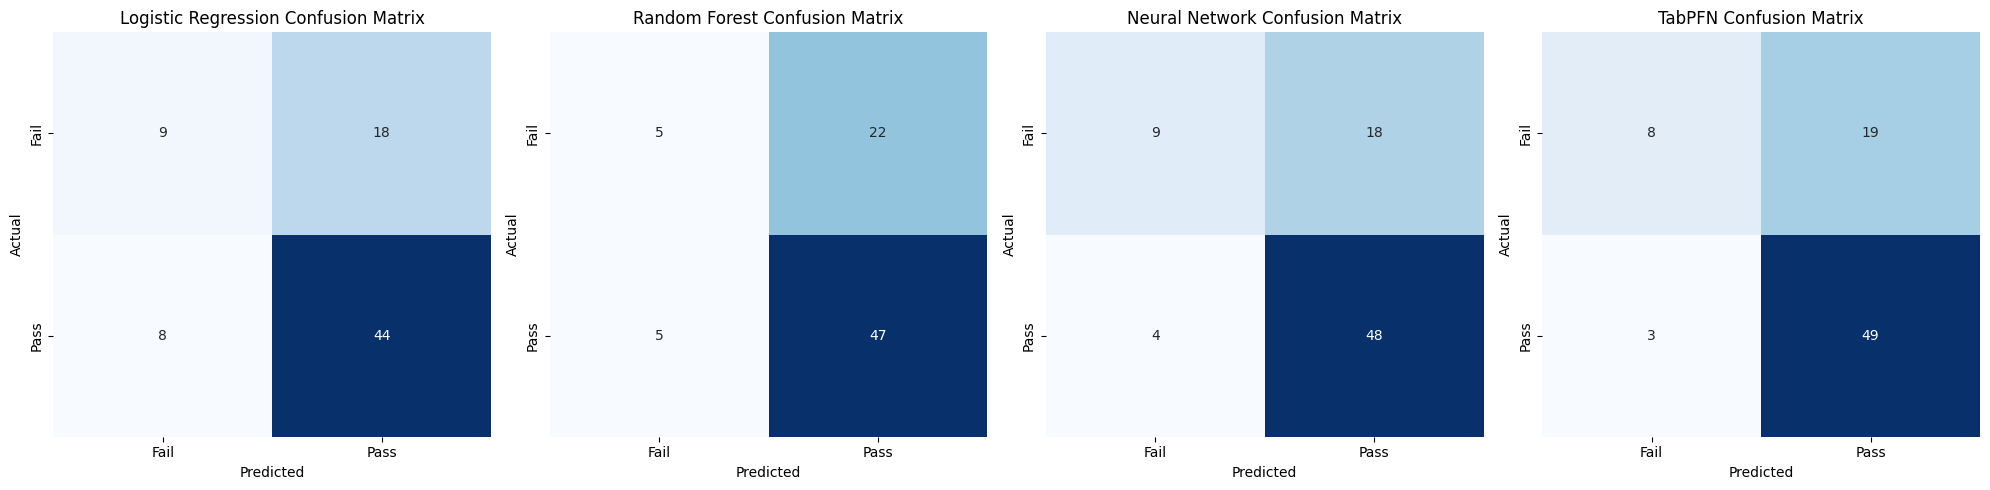

In [31]:
#20. Confusion matrices of all Classification models

# Create confusion matrix plots for all classification models
fig, axes = plt.subplots(1,4, figsize=(20,5)) # Adjusted figure size for 4 plots
y_preds = [y_pred_logreg, y_pred_rf_clf, y_pred_clf_nn, y_pred_tabpfn_clf]
titles = ['Logistic Regression', 'Random Forest', 'Neural Network', 'TabPFN']

for ax, y_p, t in zip(axes, y_preds, titles):
    # Ensure the predictions and true labels are the same type for confusion_matrix
    # For NN and TabPFN, predictions are already arrays. For others, convert if needed.
    cm = confusion_matrix(y_test_c, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{t} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    # Add class labels (assuming 0 and 1)
    ax.set_xticklabels(['Fail', 'Pass'])
    ax.set_yticklabels(['Fail', 'Pass'])


plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Calculating permutation importance for Neural Network (this may take a while)...
  Permuting feature: school
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Permuting feature: sex
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Permuting feature: age
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Permuting feature: address
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
  Permuting fe

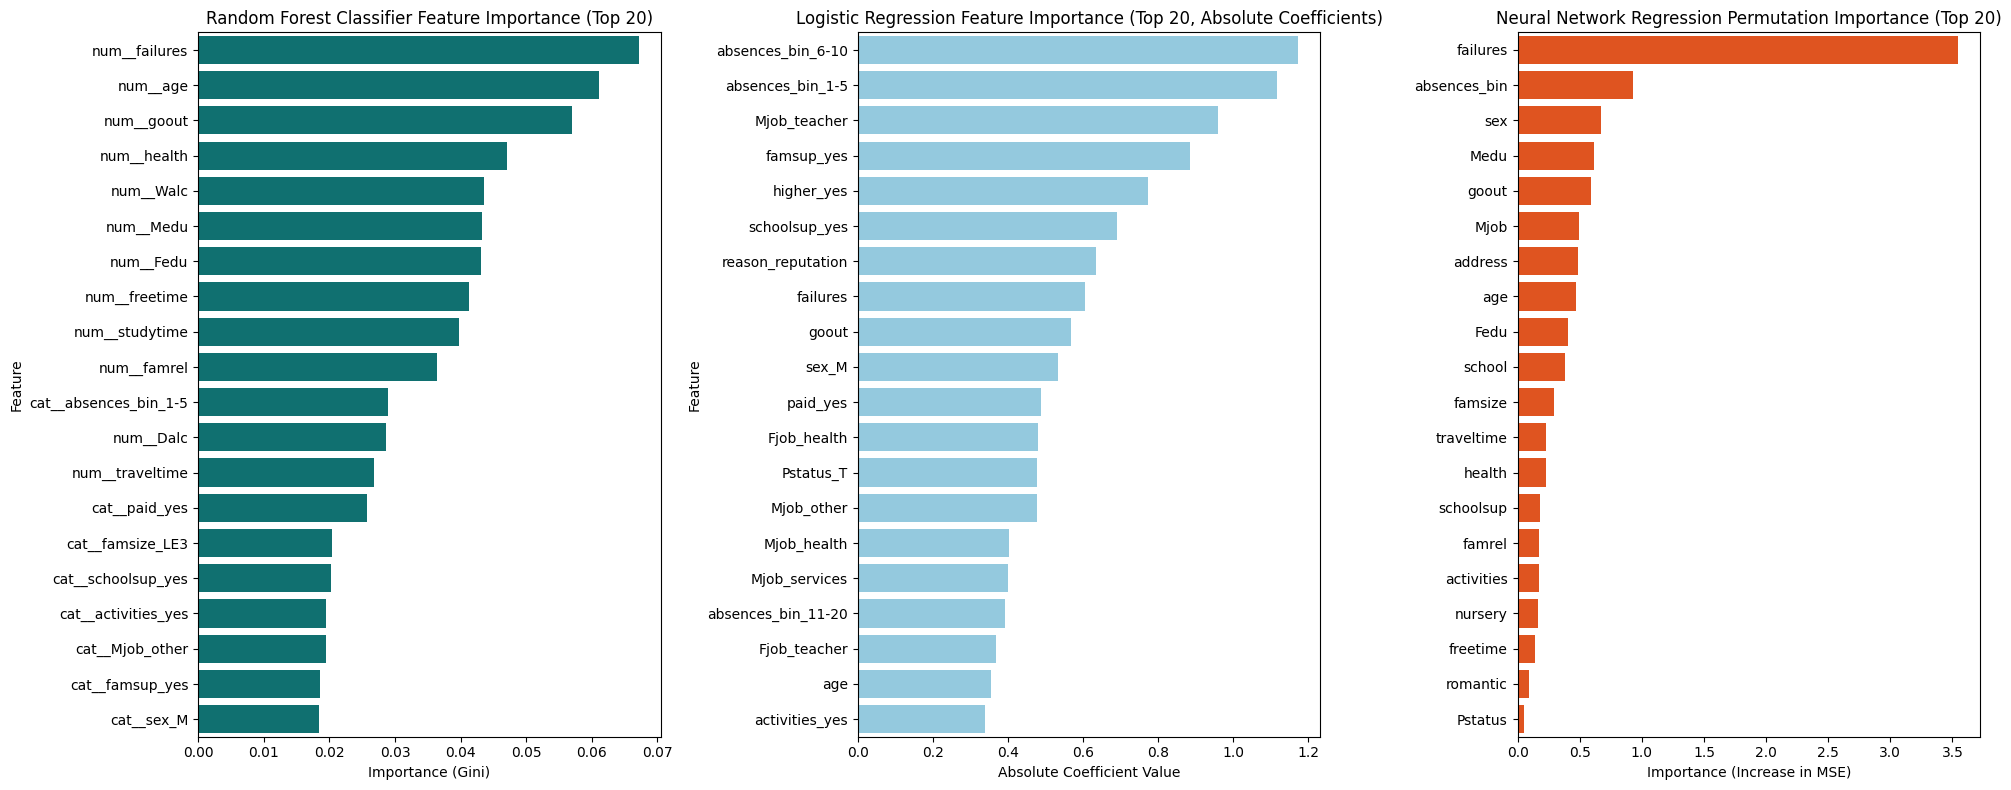

In [32]:
#21. Important features from different Classification models

from sklearn.metrics import mean_squared_error
import copy
import pandas as pd
from sklearn.inspection import permutation_importance

def permutation_importance_regression_nn(model, X_test, y_test, preprocessor, n_repeats=5):
    """
    Calculates permutation importance for a Keras regression model.

    Args:
        model: Trained Keras regression model.
        X_test: Original test DataFrame (before preprocessing).
        y_test: True test target values.
        preprocessor: The fitted ColumnTransformer.
        n_repeats: Number of times to permute each feature.

    Returns:
        A dictionary with feature names as keys and mean importance score as values.
    """
    # Get the baseline performance
    X_test_processed = preprocessor.transform(X_test).astype(np.float32)
    baseline_pred = model.predict(X_test_processed).flatten()
    baseline_loss = mean_squared_error(y_test, baseline_pred)

    feature_importance = {}
    # Get the feature names after preprocessing
    feature_names_processed = preprocessor.get_feature_names_out()

    print("Calculating permutation importance for Neural Network (this may take a while)...")

    for col in X_test.columns:
        print(f"  Permuting feature: {col}")
        feature_losses = []
        for _ in range(n_repeats):
            # Create a copy of the original test data
            X_test_permuted = X_test.copy()
            # Permute the values in the current column
            X_test_permuted[col] = np.random.permutation(X_test_permuted[col])

            # Preprocess the permuted data
            X_test_permuted_processed = preprocessor.transform(X_test_permuted).astype(np.float32)

            # Predict with the permuted data
            permuted_pred = model.predict(X_test_permuted_processed).flatten()

            # Calculate the loss with permuted data
            permuted_loss = mean_squared_error(y_test, permuted_pred)
            feature_losses.append(permuted_loss)

        # Importance is the average increase in loss
        feature_importance[col] = np.mean(feature_losses) - baseline_loss

    # Sort features by importance
    sorted_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
    return sorted_importance

# Calculate feature importance for Random Forest Classifier
rf_importance = rf_clf_model.named_steps['rf_clf'].feature_importances_
# Get the feature names after preprocessing for the RF model
rf_feature_names = preprocessor.get_feature_names_out()
rf_imp_df = pd.DataFrame({'feature': rf_feature_names, 'importance': rf_importance})
rf_imp_df = rf_imp_df.sort_values('importance', ascending=False).reset_index(drop=True).head(20)

# Calculate feature importance for Logistic Regression (using absolute coefficients)
# Need to get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names_processed = list(numeric_features) + list(ohe_feature_names)

logreg_coefficients = logreg_model.named_steps['logreg'].coef_[0] # Assuming binary classification
logreg_imp_df = pd.DataFrame({'feature': all_feature_names_processed, 'importance': np.abs(logreg_coefficients)})
logreg_imp_df = logreg_imp_df.sort_values('importance', ascending=False).reset_index(drop=True).head(20)


# Calculate permutation importance for Neural Network Regression
nn_reg_importance = permutation_importance_regression_nn(model_reg, X_test_r, y_test_r, preprocessor, n_repeats=5)
nn_reg_imp_df = pd.DataFrame(list(nn_reg_importance.items()), columns=['feature', 'importance'])


fig, axes = plt.subplots(1, 3, figsize=(20, 8)) # Adjusted figure size for 3 plots

# RF Classifier Importance Plot
sns.barplot(x='importance', y='feature', data=rf_imp_df, ax=axes[0], color='teal')
axes[0].set_title('Random Forest Classifier Feature Importance (Top 20)')
axes[0].set_xlabel('Importance (Gini)')
axes[0].set_ylabel('Feature')

# Logistic Regression Coefficient Plot
sns.barplot(x='importance', y='feature', data=logreg_imp_df, ax=axes[1], color='skyblue')
axes[1].set_title('Logistic Regression Feature Importance (Top 20, Absolute Coefficients)')
axes[1].set_xlabel('Absolute Coefficient Value')
axes[1].set_ylabel('Feature')

# NN Regression Permutation Importance Plot
sns.barplot(x='importance', y='feature', data=nn_reg_imp_df.head(20), ax=axes[2], color='orangered')
axes[2].set_title('Neural Network Regression Permutation Importance (Top 20)')
axes[2].set_xlabel('Importance (Increase in MSE)')
# Remove ylabel from the third plot for cleaner look as features are the same
axes[2].set_ylabel('')


plt.tight_layout()
plt.show()

# Note: Feature importance for TabPFN is not included as a simple method is not available.
# The NN importance shown is based on permutation on the original features, which is an estimate.

In [33]:
#22. Create the new student record for testing
new_student = pd.DataFrame({
    'school': ['GP'], 'sex': ['F'], 'age': [17], 'address': ['U'],
    'famsize': ['GT3'], 'Pstatus': ['T'], 'Medu': [2], 'Fedu': [2],
    'Mjob': ['services'], 'Fjob': ['other'], 'reason': ['reputation'],
    'guardian': ['mother'], 'traveltime': [1], 'studytime': [2],
    'failures': [0], 'schoolsup': ['yes'], 'famsup': ['no'], 'paid': ['no'],
    'activities': ['yes'], 'nursery': ['yes'], 'higher': ['yes'], 'internet': ['yes'],
    'romantic': ['no'], 'famrel': [4], 'freetime': [3], 'goout': [2],
    'Dalc': [1], 'Walc': [1], 'health': [4], 'absences_bin': ['1-5']
})

# Step 2: Ensure column order matches features
new_student = new_student[features.columns]  # Safe reorder

# Step 3: Preprocess
new_student_processed = preprocessor.transform(new_student)

# Step 4: Predictions

# Regressors
print("  Regressor Predictions (Grade):")
print("  Ridge Regression:           ", round(ridge_model.predict(new_student)[0], 2))
print("  Random Forest Regressor:    ", round(rf_reg_model.predict(new_student)[0], 2))
print("  Neural Network Regressor:   ", round(model_reg.predict(new_student_processed)[0][0], 2))
print("  TabPFN Regressor:           ", round(reg.predict(new_student_processed)[0], 2))
print("  AutoTabPFN Regressor:       ", round(auto_reg.predict(new_student_processed)[0], 2))

# Classifiers
print("  Classifier Predictions (Pass/Fail):")
print("  Logistic Regression:        ", logreg_model.predict(new_student)[0])
print("  Random Forest Classifier:   ", rf_clf_model.predict(new_student)[0])
print("  Neural Network Classifier:  ", int(model_clf.predict(new_student_processed)[0][0] > 0.5))
print("  TabPFN Classifier:          ", clf_tabpfn.predict(new_student_processed)[0])

# Probabilities
print("  Classifier Probabilities of Pass:")
print("  Logistic Regression:        ", round(logreg_model.predict_proba(new_student)[0][1], 3))
print("  Random Forest Classifier:   ", round(rf_clf_model.predict_proba(new_student)[0][1], 3))
print("  Neural Network Classifier:  ", round(model_clf.predict(new_student_processed)[0][0], 3))
print("  TabPFN Classifier:          ", round(clf_tabpfn.predict_proba(new_student_processed)[0][1], 3))


  Regressor Predictions (Grade):
  Ridge Regression:            11.69
  Random Forest Regressor:     10.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
  Neural Network Regressor:    11.67
  TabPFN Regressor:            9.95
  AutoTabPFN Regressor:        11.44
  Classifier Predictions (Pass/Fail):
  Logistic Regression:         1
  Random Forest Classifier:    1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
  Neural Network Classifier:   1
  TabPFN Classifier:           1.0
  Classifier Probabilities of Pass:
  Logistic Regression:         0.902
  Random Forest Classifier:    0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  Neural Network Classifier:   0.623
  TabPFN Classifier:           0.626
